In [151]:
import pandas as pd
import numpy as np
import pyperclip as pc

# ___________________________________________________________________
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as ms
from sklearn import datasets, svm, metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import sklearn.datasets as datasets
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# ____________________________________________________________________
from scipy import stats
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import chart_studio.plotly as py
import cufflinks as cf
import datetime as dt

#_____________________________________________________________________
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

from joblib import Parallel, delayed
import multiprocessing
from IPython.display import display, clear_output
import plotly.tools as tls
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import json

#___________________________________________________________________
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
cf.go_offline()

# tls.set_credentials_file(username='marcelofprado', api_key='cftsFWfYZ7DgpGQtDuRe')
# init_notebook_mode(connected=True)

np.seterr(divide='ignore')

{'divide': 'ignore', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [152]:
resp = pd.read_csv('respirators_brazil.csv')
resp_sum = resp['equipments'].sum()

In [168]:
italy_data = pd.read_csv('20200324_covid_data_italy.csv')
# print(italy_data)
italy_data['date'] = pd.to_datetime(italy_data['data'], format='%Y-%m-%d %H:%M:%S').dt.date
italy_data = italy_data[['date','totale_casi', 'deceduti','ricoverati_con_sintomi', 'totale_ospedalizzati', 'totale_attualmente_positivi']]
italy_data.columns = ['date','cases','deaths', 'recovered', 'hospitalized', 'active_cases']
italy_data = italy_data.set_index('date', drop=True)
italy_data['new_cases'] = italy_data['cases'].diff().fillna(0)
# italy_data

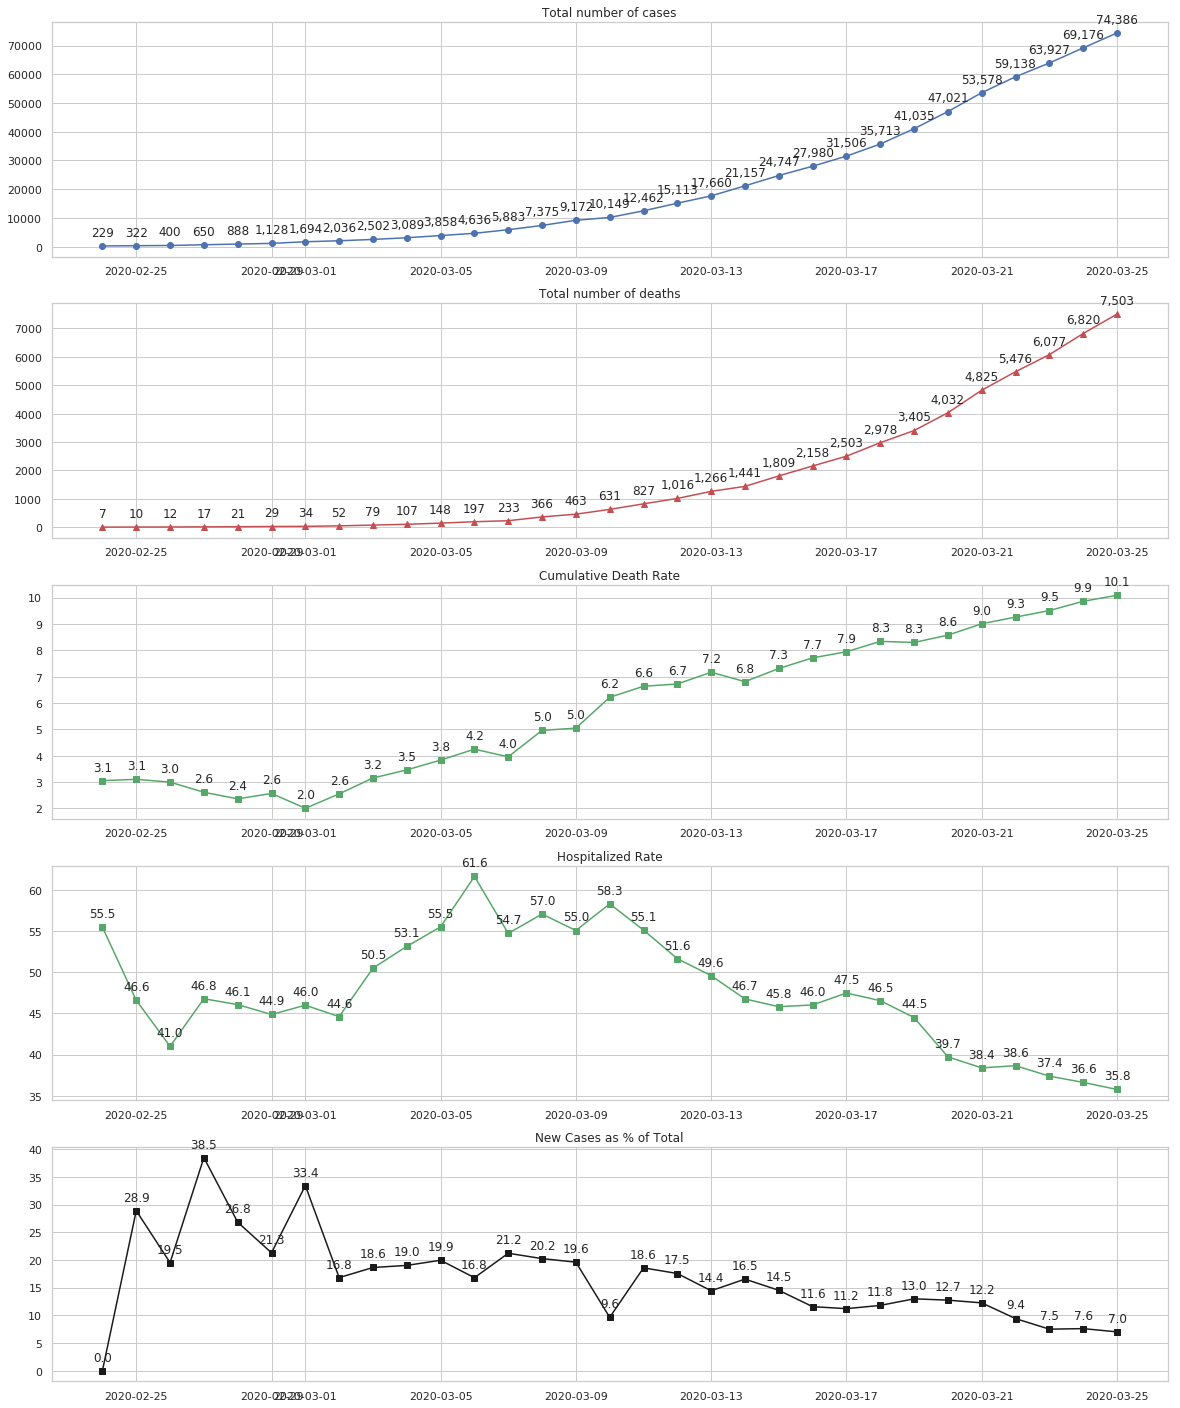

In [170]:
plt.figure(figsize = (20,25))

# plt.gca().title('Italian Cases')

plt.subplot('511')
xs = italy_data.index.values
ys = italy_data['cases']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = italy_data['deaths']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = italy_data['deaths'] / italy_data['cases'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('Hospitalized Rate')
ys = italy_data['hospitalized'] / italy_data['cases'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('515')
plt.gca().set_title('New Cases as % of Total')
ys = italy_data['new_cases'] / italy_data['cases'] * 100
plt.plot(xs, ys, 'ks-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('italian_overview')
plt.show()

In [163]:
data = np.array([
    [dt.datetime(2020,2,25) + dt.timedelta(days=i) for i in range(0,30)],
    [1,1,1,1,2,2,2,2,3,8,13,19,25,25,34,52,77,151,151,200,234,346,529,640,970,1178, 1546, 1924,2247,2433],
    [1,1,1,1,2,2,2,2,3,8,13,19,25,25,34,52,77,150,150,198,232,343,523,631,957,1158, 1519,1888,2199,2374],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,7,11,18,25,34,46,57],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0]]
).transpose()
cols = ['date','cases', 'active_cases', 'deaths', 'recovered']

brazil_data = pd.DataFrame(data, columns = cols)
brazil_data['date'] = brazil_data['date'].dt.date
brazil_data = brazil_data.set_index('date', drop=True)
brazil_data['resp_aux'] = (brazil_data.index >= (dt.datetime.strptime('2020-03-23','%Y-%m-%d')).date()) * (350 / 7)
brazil_data['resp_aux'] = brazil_data['resp_aux'].cumsum()
brazil_data['respirator'] = brazil_data['resp_aux'] + resp_sum
brazil_data['new_cases'] = brazil_data['cases'].diff().fillna(0)
brazil_data.to_csv('covid_data_brazil.csv')
# brazil_data

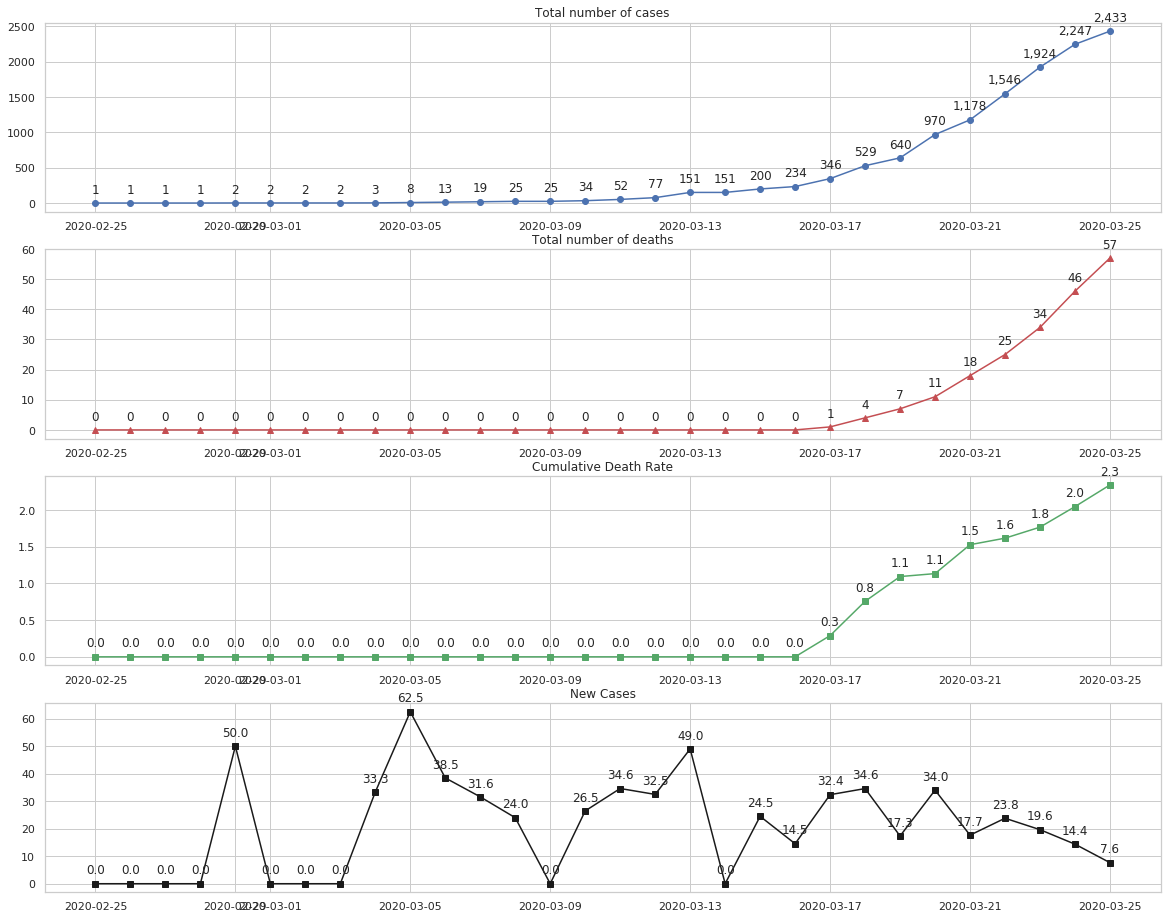

In [171]:
plt.figure(figsize = (20,16))

# plt.gca().title('Italian Cases')

plt.subplot('411')
xs = brazil_data.index.values
ys = brazil_data['cases']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('412')
plt.gca().set_title('Total number of deaths')
ys = brazil_data['deaths']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('413')
plt.gca().set_title('Cumulative Death Rate')
ys = brazil_data['deaths'] / brazil_data['cases'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('414')
plt.gca().set_title('New Cases as % of Total')
ys = brazil_data['new_cases'] / brazil_data['cases'] * 100
plt.plot(xs, ys, 'ks-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.savefig('brazil_overview')
plt.show()

In [172]:
br_data = brazil_data[20:].reset_index()
ys = ((italy_data['cases'].append(br_data['cases'])).astype(float)).values
xs = [i for i in range (0,len(italy_data['cases']))] +  [i for i in range (0,len(br_data['cases']))]
p = np.poly1d(np.polyfit(xs, np.log(ys), 2))

xse = [i for i in range(0,100)]
yse = p(xse)

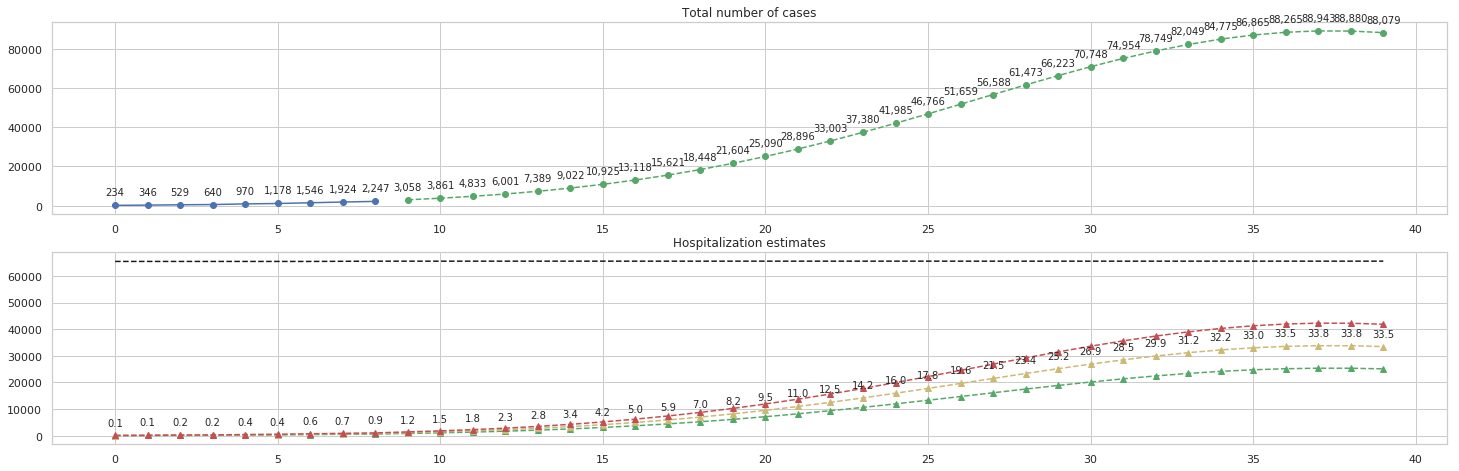

In [20]:
plt.figure(figsize = (25,12))

# plt.gca().title('Italian Cases')
n = 40
xs = range(0,n)
yse = p(range(len(br_data), n))
zs = (br_data['cases'].append(pd.Series(np.exp(yse)))).reset_index(drop = True)
ys = (br_data['cases'].append(pd.Series(np.nan for i in range(0,len(yse))))).reset_index(drop=True)
yse = (pd.Series(np.nan for i in range(0,len(br_data))).append(pd.Series(p(range(len(br_data), n))))).reset_index(drop=True)

plt.subplot('311')
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-', np.exp(yse), 'go--')
for x,y in zip(xs,zs):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('312')
plt.gca().set_title('Hospitalization estimates')
est1 = zs * 0.3 - zs * 0.015
est2 = zs * 0.4 - zs * 0.02
est3 = zs * 0.5 - zs * 0.025
rep_max = br_data['respirator'].max()
resp_line = br_data['respirator'].copy()
resp_line = ((resp_line.append(pd.Series(rep_max for i in range(0,len(p(range(len(br_data), n))))))).reset_index(drop=True)).values
plt.plot(xs, est1, 'g^--', est2, 'y^--', est3, 'r^--', resp_line, 'k--')
# for x,y in zip(xs,est1):
#     label = "{:,.1f}".format(y / 1000)
#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip(xs,est2):
    label = "{:,.1f}".format(y / 1000)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
# for x,y in zip(xs,est3):
#     label = "{:,.1f}".format(y / 1000)
#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center
    
plt.savefig('brazil_forecast')
plt.show()
# resp_line

In [173]:
data = np.array([
    [dt.datetime(2020,2,15) + dt.timedelta(days=i) for i in range(0,39)],
    [15,15,15,15,15,15,35,35,35,53,57,60,63,68,75,100,124,158,221,319,435,541,704,994,1301,1697,2247,2943,3680,4663,6411,9259,13789,19383,26111,32356,42443,53287,64775],
    [15,15,15,15,15,15,35,35,35,51,54,54,57,60,65,85,106,138,200,289,401,504,663,949,1248,1625,2157,2830,3553,4503,6196,9003,13474,18980,23729,31764,41361,53697,63472],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,6,9,11,12,15,19,22,26,30,38,41,49,57,68,86,109,150,207,256,324,414,517,780, 910]]
).transpose()
cols = ['date','cases', 'active_cases', 'deaths']

us_data = pd.DataFrame(data, columns = cols)
us_data['recovered'] = us_data['cases'] - us_data['active_cases'] - us_data['deaths']
us_data = us_data.set_index('date', drop = True)
us_data['new_cases'] = us_data['cases'].diff().fillna(0)
# print(us_data)

us_covid = pd.read_csv('us-daily.csv')
us_covid['date'] = pd.to_datetime(us_covid['date'], format='%Y%m%d')
us_covid = us_covid.set_index('date', drop = True)
us_data = us_data.merge(us_covid['total'], on='date')
# us_data['tests'] = us_data[['tests','total']].max(axis = 1)
us_data['tests'] = us_data['total']
us_data = us_data.drop('total', axis = 1)
# us_covid

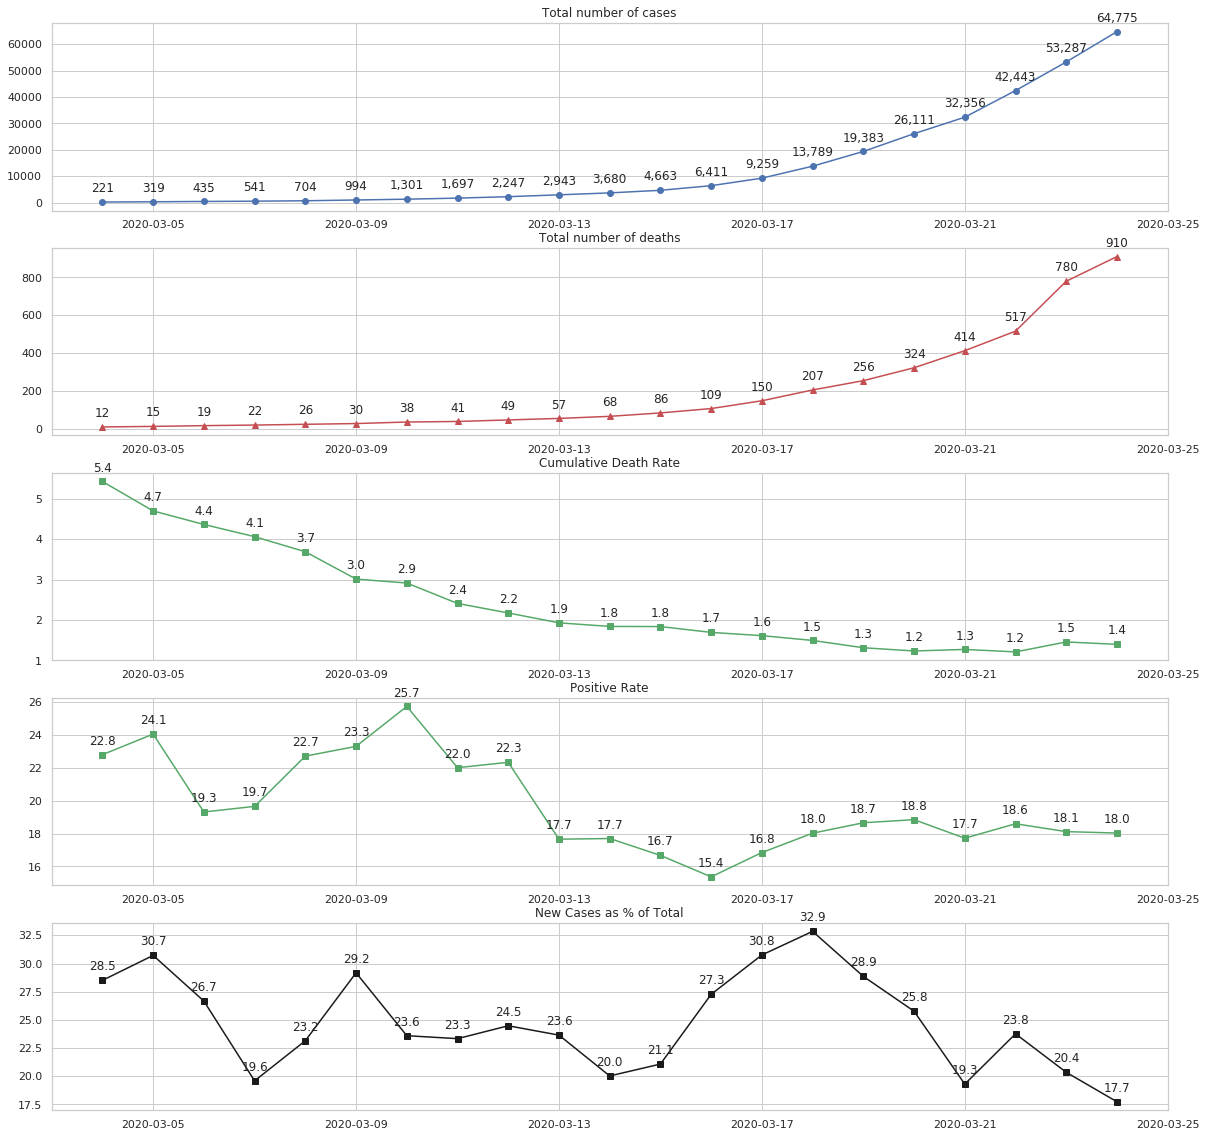

In [176]:
plt.figure(figsize = (20,20))

# plt.gca().title('Italian Cases')

plt.subplot('511')
xs = us_data.index.values
ys = us_data['cases']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = us_data['deaths']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = us_data['deaths'] / us_data['cases'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('Positive Rate')
ys = us_data['cases'] / us_data['tests'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('515')
plt.gca().set_title('New Cases as % of Total')
ys = us_data['new_cases'] / us_data['cases'] * 100
plt.plot(xs, ys, 'ks-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.savefig('us_overview')
plt.show()

In [193]:
us_covid_state = pd.read_csv('states-daily.csv')
us_covid_state['date'] = pd.to_datetime(us_covid_state['date'], format='%Y%m%d')
us_covid_state = us_covid_state.set_index('date', drop = True)
ny_covid = us_covid_state[us_covid_state['state'] == 'NY']
ny_covid = ny_covid.sort_values(by='date')
ny_covid['new_cases'] = ny_covid['positive'].diff().fillna(0)
ny_data = ny_covid.copy()
# ny_data

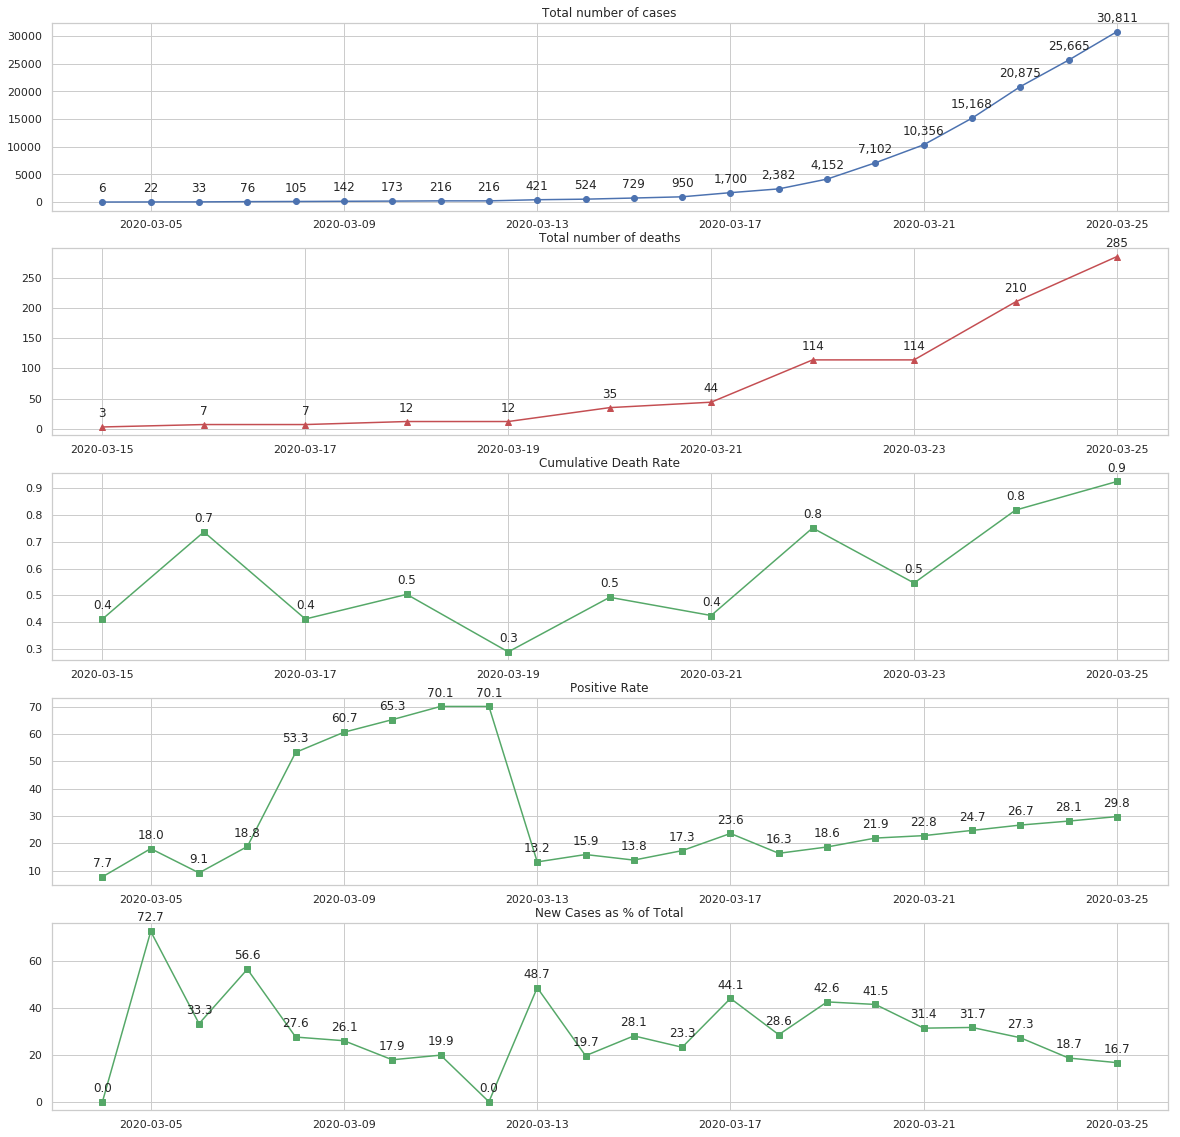

In [194]:
plt.figure(figsize = (20,20))

# plt.gca().title('Italian Cases')

plt.subplot('511')
xs = ny_data.index.values
ys = ny_data['positive']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = ny_data['death']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = ny_data['death'] / ny_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('Positive Rate')
ys = ny_data['positive'] / ny_data['total'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('515')
plt.gca().set_title('New Cases as % of Total')
ys = ny_data['new_cases'] / ny_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('ny_overview')
plt.show()

In [195]:
us_state = us_covid_state[us_covid_state.index == '2020-03-24'].set_index('state', drop = True)
us_state['positive_rate'] = us_state['positive'] / us_state['total'] * 100
us_state['death_rate'] = us_state['death'] / us_state['positive'] * 100
us_state = us_state.fillna(0)

us_state_data = pd.read_csv('us_states_data.csv')
us_state_data.columns = ['state', 'population','area-miles', 'area']
us_state_data['population'] = us_state_data['population'].str.replace(',','').astype(int)
us_state_data['area-miles'] = us_state_data['area-miles'].str.replace(',','').astype(int)
us_state_data['area'] = us_state_data['area'].str.replace(',','').astype(int)
us_state_data['density'] = us_state_data['population'].astype(float) / us_state_data['area'].astype(float)
us_state_data = us_state_data.set_index('state', drop = True)

us_state = us_state.merge(us_state_data, on='state')
us_state['tests_per_1000'] = us_state['total'] / us_state['population'] * 1000

In [196]:
us_state

,positive,negative,pending,hospitalized,death,total,dateChecked,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,positive_rate,death_rate,population,area-miles,area,density,tests_per_1000
state,,,,,,,,,,,,,,,,,,,,
AK,36.0,986.0,0.0,0.0,0.0,1022,2020-03-24T20:00:00Z,1022,0.0,0.0,40.0,14.0,54.0,3.522505,0.000000,731545,665384,1723337,0.424493,1.397043
AL,215.0,2106.0,0.0,0.0,0.0,2321,2020-03-24T20:00:00Z,2321,0.0,0.0,441.0,48.0,489.0,9.263249,0.000000,4903185,52420,135767,36.114704,0.473366
AR,218.0,947.0,0.0,22.0,0.0,1165,2020-03-24T20:00:00Z,1165,0.0,9.0,41.0,44.0,85.0,18.712446,0.000000,3017804,53179,137732,21.910696,0.386042
AZ,357.0,313.0,22.0,8.0,5.0,692,2020-03-24T20:00:00Z,670,3.0,8.0,4.0,92.0,96.0,51.589595,1.400560,7278717,113990,295234,24.654061,0.095072
CA,2102.0,13452.0,12100.0,0.0,40.0,27654,2020-03-24T20:00:00Z,15554,13.0,0.0,885.0,369.0,1254.0,7.601070,1.902950,39512223,163695,423967,93.196459,0.699885
CO,720.0,5504.0,0.0,72.0,7.0,6224,2020-03-24T20:00:00Z,6224,1.0,14.0,659.0,129.0,788.0,11.568123,0.972222,5758736,104094,269601,21.360218,1.080793
CT,618.0,4682.0,0.0,71.0,12.0,5300,2020-03-24T20:00:00Z,5300,2.0,17.0,597.0,203.0,800.0,11.660377,1.941748,3565278,5543,14357,248.330292,1.486560
DE,91.0,36.0,0.0,0.0,0.0,127,2020-03-24T20:00:00Z,127,0.0,0.0,0.0,23.0,23.0,71.653543,0.000000,973764,2489,6446,151.064846,0.130422
FL,1412.0,13127.0,1008.0,259.0,18.0,15547,2020-03-24T20:00:00Z,14539,4.0,42.0,2064.0,241.0,2305.0,9.082138,1.274788,21477737,65758,170312,126.108184,0.723866


In [197]:
# us_state.sort_values(by='positive_rate', ascending=False)
df_corr = us_state[['tests_per_1000','positive_rate','death_rate','density']].sort_values(by='tests_per_1000', ascending=False).corr()

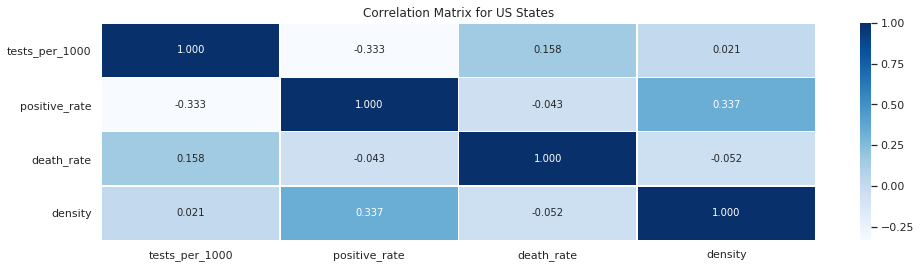

In [76]:
plt.figure(figsize = (16,4))
title = 'Correlation Matrix for US States'
# df_result = df_count.div(df_count.sum(axis = 0).sum(), axis = 1) * 100
plt.title(title)
sns.heatmap(df_corr, annot = True, linewidths = 0.5, cmap='Blues', fmt=',.3f')
plt.savefig(title)

In [135]:
br_state = pd.read_csv('brazil_covid19.csv')
br_state['total'] = br_state['cases'] + br_state['refuses']
br_state['total_susp'] = br_state['cases'] +  br_state['refuses'] + br_state['suspects']
br_state['positive_rate'] = br_state['cases'] / br_state['total'] * 100
br_state = br_state[br_state['date'] == '2020-03-24']
br_state = br_state.set_index('state', drop=True)
br_state['death_rate'] = br_state['deaths'] / br_state['cases'] * 100

br_state_data = pd.read_csv('br_states_data.csv')
br_state_data = br_state_data.drop(['Bandeira', 'Sede de governo','Alfabetização (2016)', 'Mortalidade infantil (2016)', 'Expectativa de vida (2016)'], axis = 1)
br_state_data.columns = ['state', 'state_2digits', 'area', 'population', 'density', 'gdp', 'share','gdp_per_capita', 'hdi']
br_state_data = br_state_data.set_index('state', drop=True)
br_state_data = br_state.merge(br_state_data, on='state')
br_state_data['area'] = br_state_data['area'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['population'] = br_state_data['population'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['gdp'] = br_state_data['gdp'].str.replace(',','').str.replace('\xa0','').astype(float)
br_state_data['gdp_per_capita'] = br_state_data['gdp_per_capita'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['hdi'] = br_state_data['hdi'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['density'] = br_state_data['density'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['tests_per_1000'] = br_state_data['total'] / br_state_data['population'] * 1000
# br_state_data = br_state_data.set_index('state_2digits', drop = True)
br_state_data

,date,hour,suspects,refuses,cases,deaths,total,total_susp,positive_rate,death_rate,state_2digits,area,population,density,gdp,share,gdp_per_capita,hdi,tests_per_1000
state,,,,,,,,,,,,,,,,,,,
Acre,2020-03-24,NaN,248,224,21,0,245,493,8.571429,0.000000,AC,164122.2,795145.0,4.30,1.362200e+07,"0,2",16953.46,0.663,0.308120
Alagoas,2020-03-24,NaN,0,0,7,0,7,7,100.000000,0.000000,AL,27767.7,3327551.0,108.61,4.636400e+07,"0,8",13877.53,0.631,0.002104
Amapá,2020-03-24,NaN,84,70,1,0,71,155,1.408451,0.000000,AP,142814.6,756500.0,4.16,1.386100e+07,"0,2",18079.54,0.708,0.093853
Amazonas,2020-03-24,NaN,0,0,47,0,47,47,100.000000,0.000000,AM,1570745.7,3893763.0,2.05,8.656000e+07,"1,4",21978.95,0.674,0.012071
Bahia,2020-03-24,NaN,725,0,76,0,76,801,100.000000,0.000000,BA,564692.7,15150143.0,24.46,2.450250e+08,"4,1",16115.89,0.660,0.005016
Ceará,2020-03-24,NaN,0,0,185,0,185,185,100.000000,0.000000,CE,148825.6,8867448.0,54.40,1.306210e+08,"2,2",14669.14,0.682,0.020863
Distrito Federal,2020-03-24,NaN,3666,2423,161,0,2584,6250,6.230650,0.000000,DF,5822.1,2867869.0,400.73,2.156130e+08,"3,6",73971.05,0.824,0.901017
Espírito Santo,2020-03-24,NaN,0,0,40,0,40,40,100.000000,0.000000,ES,46077.5,3894899.0,73.97,1.203630e+08,2,30627.45,0.740,0.010270
Goiás,2020-03-24,NaN,765,170,27,0,197,962,13.705584,0.000000,GO,340086.7,6551322.0,16.52,1.736320e+08,"2,9",26265.32,0.735,0.030070


In [203]:
br_state_data[['tests_per_1000','positive_rate','death_rate','density']].sort_values(by='tests_per_1000', ascending=False)

,tests_per_1000,positive_rate,death_rate,density
state,,,,
Distrito Federal,0.901017,6.230650,0.000000,400.73
Acre,0.308120,8.571429,0.000000,4.30
Paraná,0.172245,3.657262,0.000000,51.48
Mato Grosso do Sul,0.106460,8.571429,0.000000,6.34
Amapá,0.093853,1.408451,0.000000,4.16
Rio Grande do Sul,0.083540,11.940299,0.000000,38.49
Sergipe,0.036367,18.518519,0.000000,89.81
Goiás,0.030070,13.705584,0.000000,16.52
Pará,0.027157,2.272727,0.000000,5.58


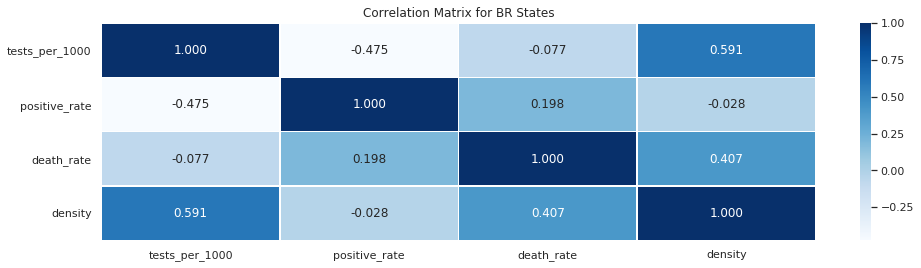

In [202]:
df_corr = br_state_data[['tests_per_1000','positive_rate','death_rate','density']].sort_values(by='tests_per_1000', ascending=False).corr()
plt.figure(figsize = (16,4))
title = 'Correlation Matrix for BR States'
# df_result = df_count.div(df_count.sum(axis = 0).sum(), axis = 1) * 100
plt.title(title)
sns.heatmap(df_corr, annot = True, linewidths = 0.5, cmap='Blues', fmt=',.3f')
plt.savefig(title)

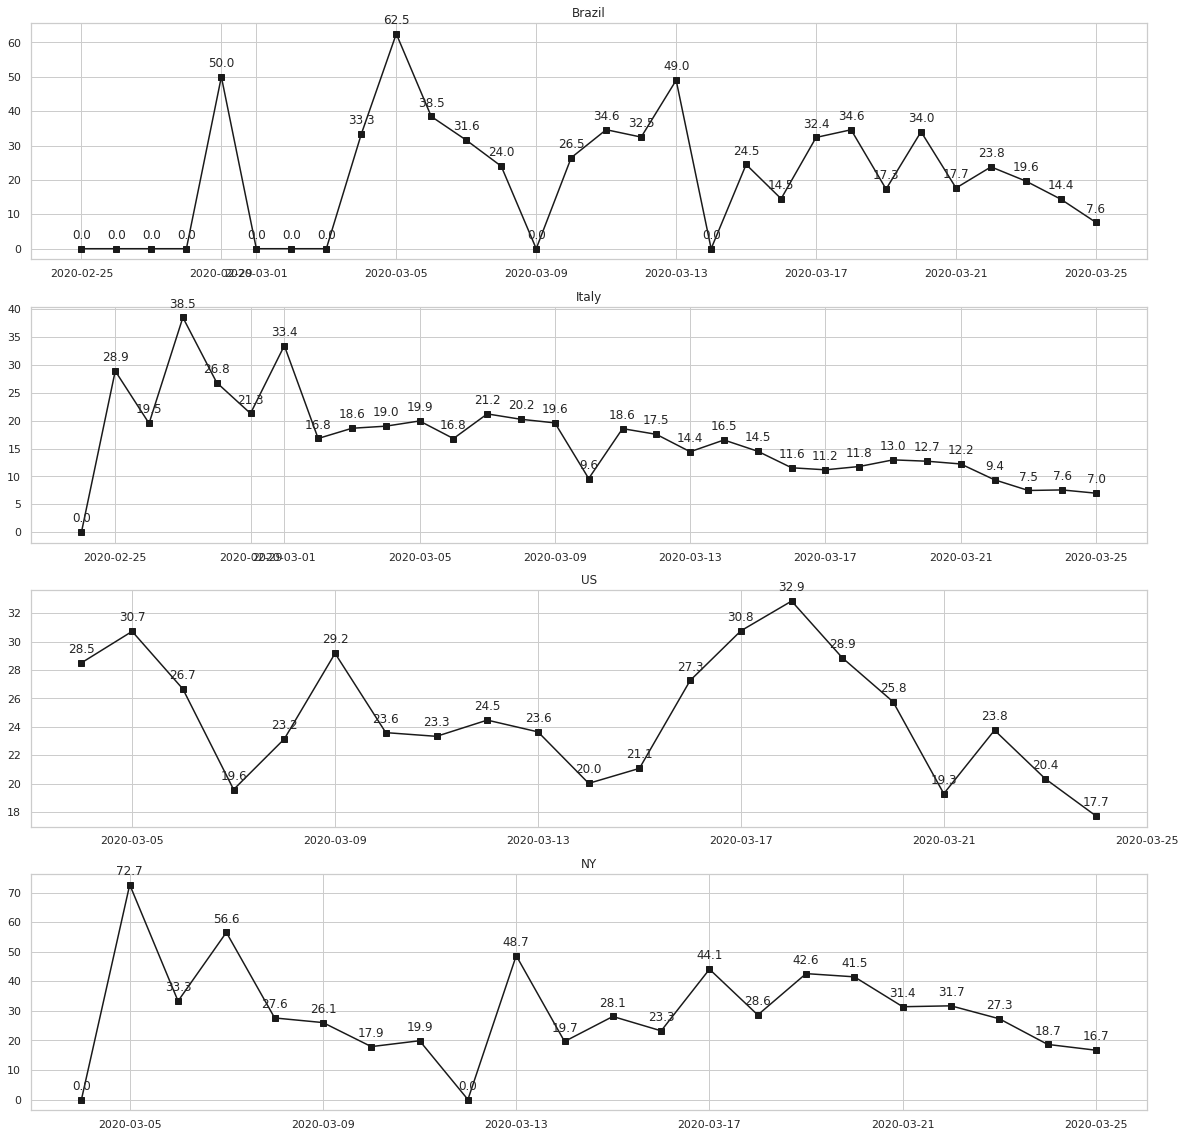

In [209]:
plt.figure(figsize = (20,20))

plt.subplot('411')
plt.gca().set_title('Brazil')
ys = brazil_data['new_cases'] / brazil_data['cases'] * 100
plt.plot(brazil_data.index, ys, 'ks-')
for x,y in zip(brazil_data.index,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('412')
plt.gca().set_title('Italy')
ys = italy_data['new_cases'] / italy_data['cases'] * 100
plt.plot(italy_data.index, ys, 'ks-')
for x,y in zip(italy_data.index,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    
plt.subplot('413')
plt.gca().set_title('US')
ys = us_data['new_cases'] / us_data['cases'] * 100
plt.plot(us_data.index, ys, 'ks-')
for x,y in zip(us_data.index,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('414')
plt.gca().set_title('NY')
ys = ny_data['new_cases'] / ny_data['positive'] * 100
plt.plot(ny_data.index, ys, 'ks-')
for x,y in zip(ny_data.index,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.savefig('new_cases_comparison')
plt.show()